<font size="18"> External Source Operator Example </font>

This application demonstrates a simple rocAL pipeline with External Source Operator supported by rocAL.

<font size="12"> Common Code </font>

In [1]:
from amd.rocal.plugin.generic import ROCALClassificationIterator
from amd.rocal.pipeline import Pipeline
import amd.rocal.fn as fn
import amd.rocal.types as types 
import random
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
class BrightnessParameters:
    def get_brightness_values(self,count):
        brightness_vals = np.random.uniform(10.0, 100.0, count)
        brightness_vals = brightness_vals.tolist()
        return brightness_vals

    def get_brightness_shift(self,count):
        brightness_shift_vals = np.random.uniform(10.0, 100.0, count)
        brightness_shift_vals = brightness_shift_vals.tolist()
        return brightness_shift_vals

In [3]:
class ContrastParameters:
    def get_contrast_values(self, count):
        contrast_vals = np.random.uniform(10.0, 100.0, count)
        contrast_vals = contrast_vals.tolist()
        return contrast_vals

    def get_contrast_center(self, count):
        contrast_center = np.random.uniform(10.0, 100.0, count)
        contrast_center = contrast_center.tolist()
        return contrast_center

In [4]:
class BlurParameters:
    def get_window_size(self, count):
        res = []
        for j in range(count):
            res.append(random.randint(0, 9))
        return res

In [5]:
batch_size = 1
num_threads = 1
device_id = 0
local_rank = 0
world_size = 1
rocal_cpu = True
random_seed = 0
max_height = 720
max_width = 640
color_format = types.RGB
data_path="/media/MIVisionX-data/rocal_data/coco/coco_10_img/train_10images_2017/"
decoder_device = 'cpu'

In [6]:
pipe = Pipeline(batch_size=batch_size, num_threads=num_threads, device_id=device_id, seed=random_seed, rocal_cpu=rocal_cpu, tensor_layout=types.NHWC , tensor_dtype=types.FLOAT, output_memory_type=types.HOST_MEMORY if rocal_cpu else types.DEVICE_MEMORY)

OK: loaded 115 kernels from libvx_rpp.so
Pipeline has been created succesfully


In [7]:
#Module 5
with pipe:
    jpegs, _ = fn.readers.file(file_root=data_path)
    images = fn.decoders.image(jpegs,
                                file_root=data_path,
                                device=decoder_device,
                                max_decoded_width=max_width,
                                max_decoded_height=max_height,
                                output_type=color_format,
                                shard_id=local_rank,
                                num_shards=world_size,
                                random_shuffle=False)
    brightness_params = BrightnessParameters()
    blur_params = BlurParameters()
    contrast_params = ContrastParameters()
    brightness_vals = fn.external_source(images, source = brightness_params.get_brightness_values, size=batch_size)
    brightness_shift_vals = fn.external_source(images, source = brightness_params.get_brightness_shift, size=batch_size)
    contrast_vals = fn.external_source(images, source = contrast_params.get_contrast_values, size=batch_size)
    contrast_center_vals = fn.external_source(images, source = contrast_params.get_contrast_center, size=batch_size)
    window_size = fn.external_source(images, source = blur_params.get_window_size, size=batch_size)
    brightness_output = fn.brightness(images, brightness=brightness_vals, brightness_shift=brightness_shift_vals)
    contrast_output = fn.contrast(images, contrast_center=contrast_vals , contrast = contrast_center_vals)
    blur_output = fn.blur(images, window_size = window_size)

    pipe.set_outputs(brightness_output, contrast_output, blur_output)
    

In [8]:
pipe.build()

In [9]:
data_loader = ROCALClassificationIterator(
    pipe, device="cpu", device_id=local_rank)

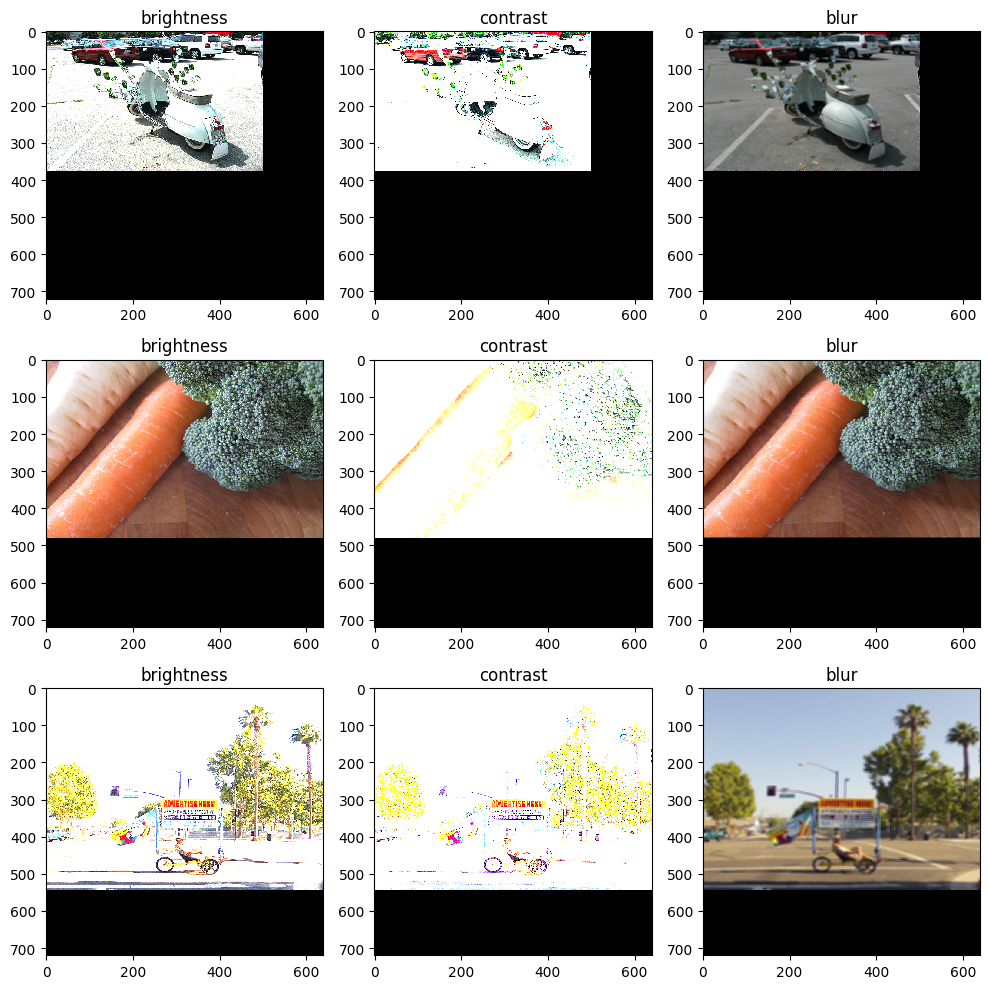

In [10]:
aug_list = ["brightness", "contrast", "blur"] 
fig, axes = plt.subplots(nrows=3, ncols=3, figsize=(10,10))
row = 0

for i, it in enumerate(data_loader, 0):
    col = 0
    cnt = 0
    for img in it[0]:
        if cnt < min(len(aug_list), len(it[0])):
            axes[row, col].set_title(aug_list[cnt])
        img = (img[0]).astype('uint8')
        axes[row, col].imshow(img,interpolation='none', aspect='auto')
        cnt += 1
        col += 1
        if col == 3:
            col = 0
    row += 1
    if row == 3:
        break
plt.tight_layout()  # Adjust subplot parameters
plt.show()
data_loader.reset()

# 